Install packages

In [69]:
print("Installed")

Installed


In [70]:
from data.InformationForCity import InformationForCity
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import *
import requests
from IPython.display import display
import ipywidgets as widgets
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.style.use('ggplot')
%matplotlib inline
import os

In [71]:
print(gpd.show_versions())


SYSTEM INFO
-----------
python     : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
executable : C:\Users\Darvin\anaconda3\envs\data-parser-staedte\python.exe
machine    : Windows-10-10.0.19041-SP0

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.0.2
GDAL data dir: None
PROJ       : 6.2.1
PROJ data dir: C:\Users\Darvin\anaconda3\envs\data-parser-staedte\Library\share\proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.9.0
pandas     : 1.3.3
fiona      : 1.8.13.post1
numpy      : 1.20.3
shapely    : 1.7.1
rtree      : 0.9.7
pyproj     : 2.6.1.post1
matplotlib : 3.4.2
mapclassify: 2.4.3
geopy      : None
psycopg2   : None
geoalchemy2: None
pyarrow    : None
pygeos     : None
None


In [72]:
services = ["Nominatim-API", "GoogleAPI", "Here-API"]


def request_data(endpoint, params):
    r = requests.get(endpoint, params)
    if not r.text:
        return None
    return r.json()

top_cities = {
    'Berlin': (13.404954, 52.520008),
    'Köln': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'München': (11.576124, 48.137154),
    'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nürnberg': (11.077438, 49.449820),
    'Hannover': (9.73322, 52.37052)
}

Select the city from which the data should get loaded

In [73]:
plz_shape_df = gpd.read_file('F:\Praxisphase\Localisation\data-parser-staedte\image-generation\csv\plz-gebiete.shp',
                             dtype={'plz': str})

plz_region_df = pd.read_csv(
    'F:\Praxisphase\Localisation\data-parser-staedte\image-generation\csv\zuordnung_plz_ort.csv',
    sep=',',
    dtype={'plz': str}
)
plz_region_df.drop('osm_id', axis=1, inplace=True)
plz_einwohner_df = pd.read_csv(
    'F:\Praxisphase\Localisation\data-parser-staedte\image-generation\csv\plz_einwohner.csv',
    sep=',',
    dtype={'plz': str, 'einwohner': int}
)
germany_df = pd.merge(
    left=plz_shape_df,
    right=plz_region_df,
    on='plz',
    how='inner'
)
germany_df = pd.merge(
    left=germany_df,
    right=plz_einwohner_df,
    on='plz',
    how='left'
)

Generation Bild: Fehler pro Service. No house number

In [74]:
def distance_per_plz(plz: str, city: str, _service: str, _correct: str):
    res = request_data("http://localhost:10001/distancePerPlz", {'plz': plz, 'correct': _correct ,'service': _service})
    if res is None:
        new_plz = request_data("http://localhost:10001/savedPlzForCity", {'city': city, 'plz': plz})
        if new_plz != "null":
            res = request_data("http://localhost:10001/distancePerPlz", {'plz': new_plz, 'service': _service, 'correct': _correct})
        else:
            print(f"{city} {plz} {new_plz} {res}")
    if res['average'] == 301:
        return None
    return res['average']

for correct_accepted in services:
    for service in services:
        if service != correct_accepted:
            germany_df['no_house_number_' + correct_accepted + service ] = germany_df.apply(
                lambda row: distance_per_plz(row['plz'], row['ort'], service, correct_accepted), axis=1)
print("finished")

finished


In [75]:
no_plz_count = 0


def points_per_plz(plz: str, city: str, _service: str):
    res = request_data("http://localhost:10001/pointsPerPLZ", {'plz': plz, 'service': _service})
    if res == 0:
        new_plz = request_data("http://localhost:10001/savedPlzForCity", {'city': city, 'plz': plz})
        if new_plz != "null":
            res = request_data("http://localhost:10001/pointsPerPLZ", {'plz': new_plz, 'service': _service})
        else:
            print(f"{city} {plz} {new_plz} {res}")
    if res == 0:
        print(f"2 response: {city} {plz} {res} {_service}")

    return res


for service in services:
    germany_df['points_per_plz_' + service] = germany_df.apply(
        lambda row: points_per_plz(row['plz'], row['ort'], service), axis=1)
print(no_plz_count)

0


In [76]:
germany_df_by_plz = germany_df.groupby('plz').first().reset_index()

#states = germany_df.dissolve(by='bundesland')

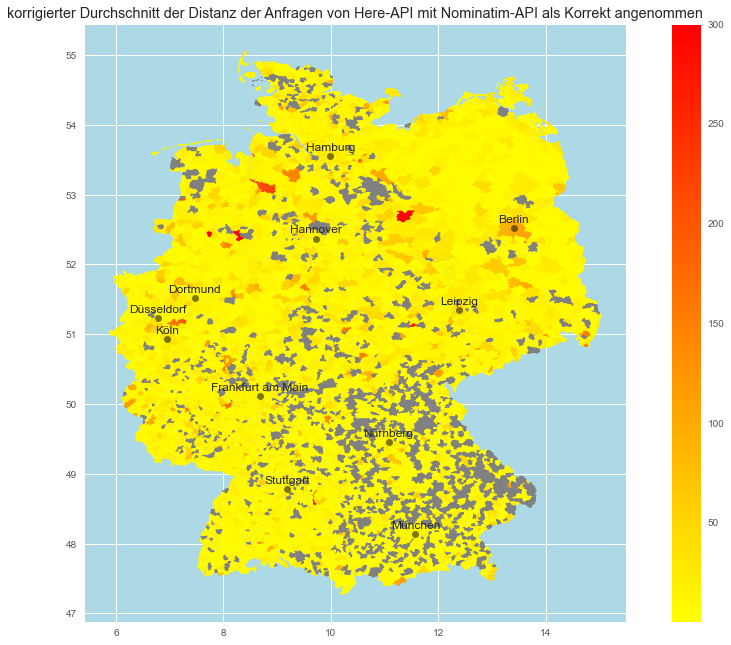

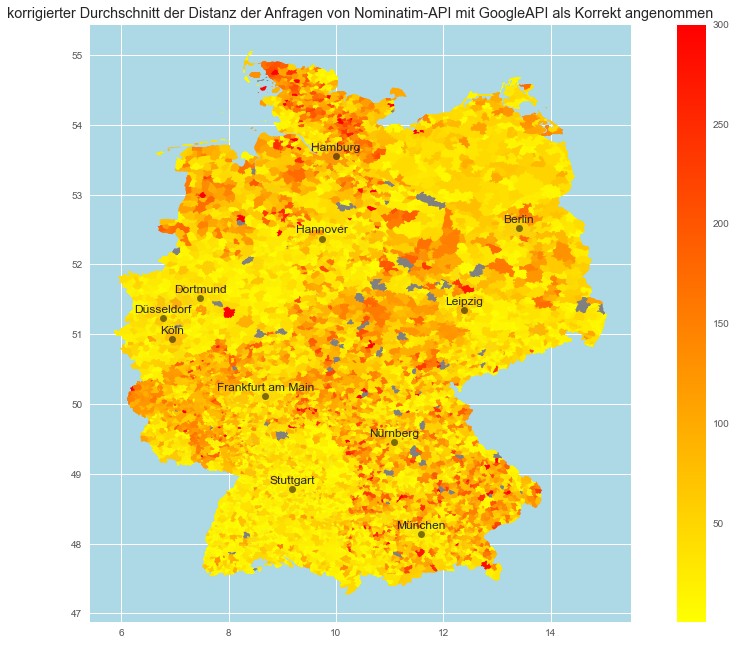

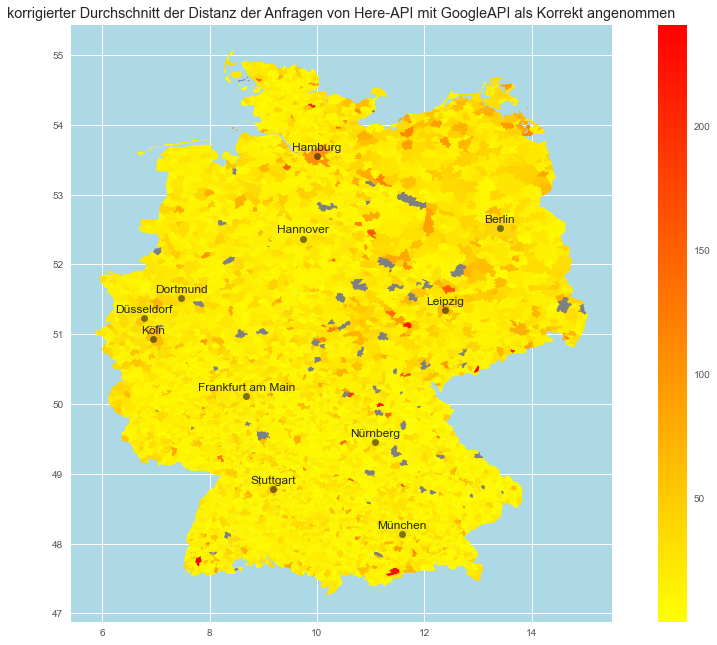

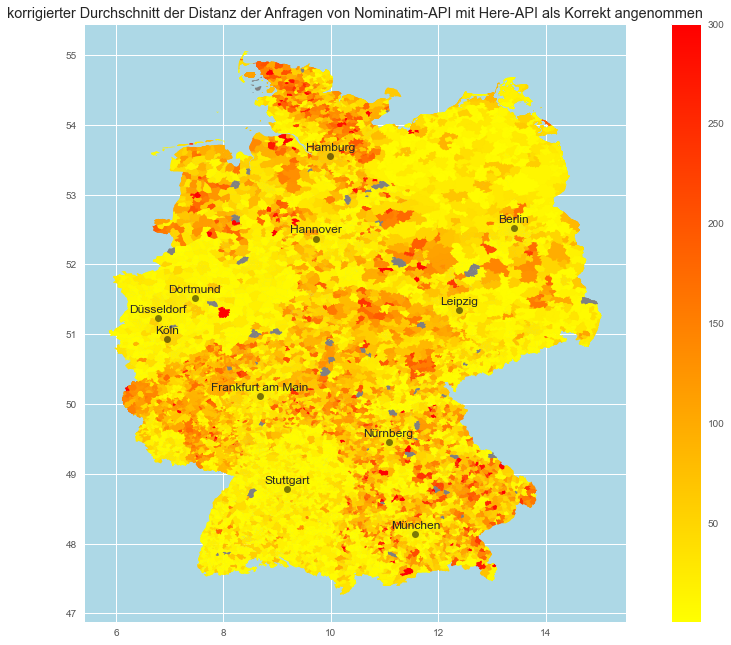

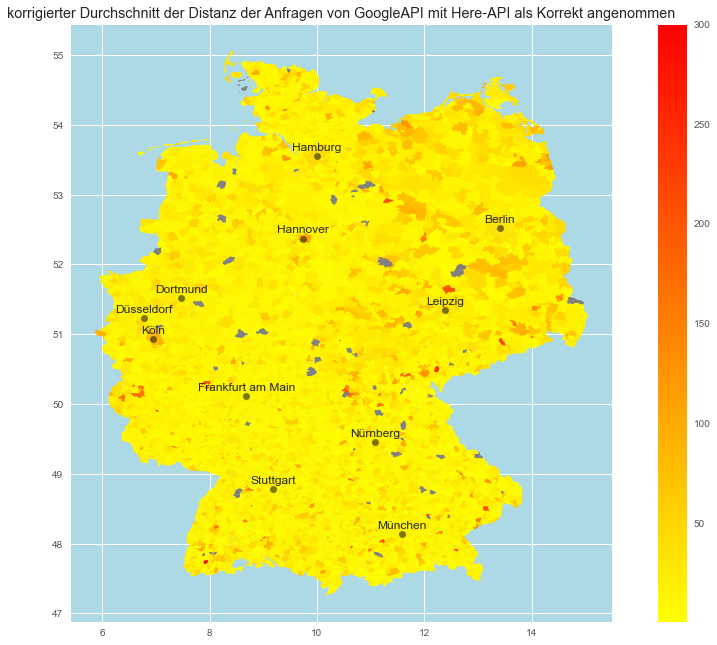

In [80]:
for correct_accepted in services:

    for service in services:
        if correct_accepted == service:
            continue
        plt.rcParams['figure.figsize'] = [16, 11]
        fig, ax = plt.subplots()
        missing_kwds = dict(color='grey', label='Keine Daten')
        germany_df.plot(
            ax=ax,
            column='no_house_number_' + correct_accepted + service,
            categorical=False,
            legend=True,
            cmap='autumn_r',
            missing_kwds=missing_kwds,
            alpha=1,
        )

        germany_df_by_plz.plot(
            ax=ax,
            column='no_house_number_' + correct_accepted + service,
            categorical=False,
            cmap='autumn_r',
            missing_kwds=missing_kwds,
            alpha=1,
        )

        ax.set(
            title=f'korrigierter Durchschnitt der Distanz der Anfragen von {service} mit {correct_accepted} als Korrekt angenommen',
            aspect=1.3,
            facecolor='lightblue'
        )

        for c in top_cities.keys():
            # Plot city name.
            ax.text(
                x=top_cities[c][0],
                # Add small shift to avoid overlap with point.
                y=top_cities[c][1] + 0.08,
                s=c,
                fontsize=12,
                ha='center',
            )
            # Plot city location centroid.
            ax.plot(
                top_cities[c][0],
                top_cities[c][1],
                marker='o',
                c='black',
                alpha=0.5
            )

        plt.savefig(f'distance-{correct_accepted}-{service}.png')

In [78]:
print(list(set(germany_df['bundesland'])))

['Nordrhein-Westfalen', 'Hamburg', 'Sachsen-Anhalt', 'Saarland', 'Bayern', 'Mecklenburg-Vorpommern', 'Hessen', 'Schleswig-Holstein', 'Baden-Württemberg', 'Brandenburg', 'Thüringen', 'Berlin', 'Rheinland-Pfalz', 'Bremen', 'Niedersachsen', 'Sachsen']


In [79]:
germany_df.to_excel(f'germany_df.xlsx', index=False)

ModuleNotFoundError: No module named 'openpyxl'